In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'

In [18]:
data = pd.read_excel('财政部-中国国债收益率曲线历史数据2025年08月31日—2025年09月30日.xlsx')

c:\Users\xlf\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


--- 方法一: 对收益率变动 (ΔY) 应用 PCA ---
解释的方差比例 (ΔY):


array([0.66021982, 0.10805666, 0.08906482])

前三主成分累计解释方差:


0.8573412942794829


主成分载荷 (ΔY):
                      3月      6月      1年      2年      3年      5年      7年  \
PC1 (Level)      0.0956  0.1038  0.1019  0.2434  0.1019  0.4745  0.5293   
PC2 (Slope)      0.6536  0.3818  0.1009  0.1824  0.0692 -0.0284  0.2468   
PC3 (Curvature)  0.4142  0.4239 -0.1160 -0.5221 -0.0848 -0.1499 -0.1005   

                    10年     30年  
PC1 (Level)      0.4699  0.4171  
PC2 (Slope)     -0.1074 -0.5528  
PC3 (Curvature) -0.0965  0.5600  

--- 方法二: 对零息票债券价格变动 (ΔP) 应用 PCA ---
解释的方差比例 (ΔP): [0.92415755 0.06189806 0.01004767]
前三主成分累计解释方差: 0.996103282178016

主成分载荷 (ΔP):
          3月      6月      1年      2年      3年      5年      7年     10年     30年
PC1  0.0005  0.0025  0.0028  0.0160  0.0121  0.1132  0.1691  0.2366  0.9498
PC2  0.0058  0.0043  0.0310  0.1024  0.0660  0.3422  0.5546  0.6800 -0.3116
PC3  0.0137  0.0248 -0.0312  0.1256 -0.1430  0.1654  0.7088 -0.6572  0.0176


c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


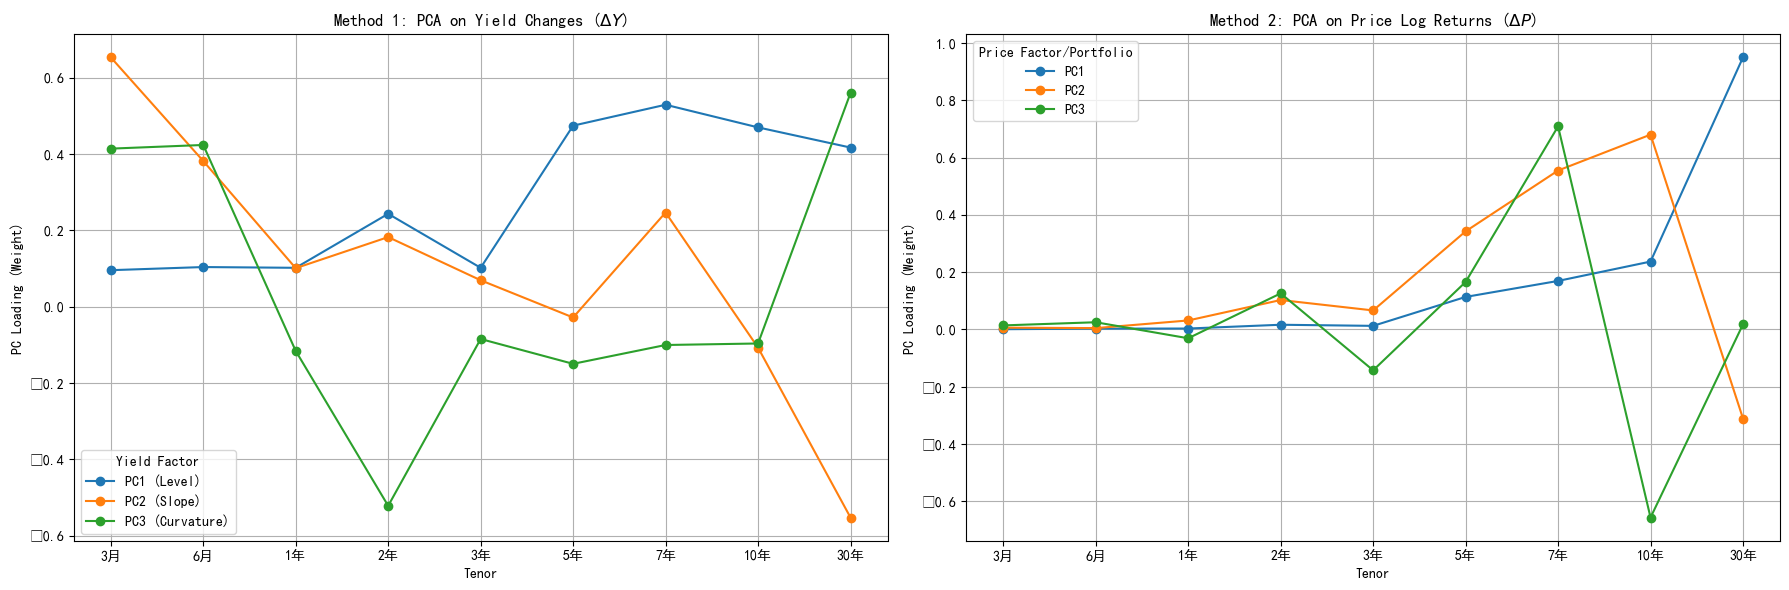


--- 差异对比 ---
方法一 (ΔY) 累计解释方差: 85.73%
方法二 (ΔP) 累计解释方差: 99.61%

载荷形状的主要差异:
PC1 (Level): 方法二的载荷在长期限上往往比方法一更高/更平坦。
这反映了长期债券价格对利率的敏感性更高（久期效应）。


In [20]:
df = data.copy()
df['日期'] = pd.to_datetime(df['日期'])
df = df.sort_values(by='日期') # 确保时间序列顺序正确
df = df.set_index('日期')
yields = df.copy() # 收益率数据 (Y)
yields = yields / 100 # 转换为小数形式

# 期限（以年为单位）
tenors = np.array([3/12, 6/12, 1, 2, 3, 5, 7, 10, 30])

# --- 方法一：对收益率变动 (ΔY) 应用 PCA ---
print("--- 方法一: 对收益率变动 (ΔY) 应用 PCA ---")
# 1. 计算日变动（差分）
yield_changes = yields.diff().dropna()

# 2. 应用 PCA
pca_yield = PCA(n_components=3)
pca_yield.fit(yield_changes)

# 3. 结果分析
explained_variance_ratio_yield = pca_yield.explained_variance_ratio_
print("解释的方差比例 (ΔY):")
display(explained_variance_ratio_yield)
print("前三主成分累计解释方差:")
display(explained_variance_ratio_yield.sum())

# 4. 主成分载荷 (特征向量)
loadings_yield = pd.DataFrame(pca_yield.components_, columns=yields.columns, index=['PC1 (Level)', 'PC2 (Slope)', 'PC3 (Curvature)'])
print("\n主成分载荷 (ΔY):\n", loadings_yield.round(4))


# --- 方法二：对零息票债券价格变动 (ΔP) 应用 PCA ---
print("\n--- 方法二: 对零息票债券价格变动 (ΔP) 应用 PCA ---")

# 1. 收益率转换为零息票债券价格（假设连续复利）
# P(T) = exp(-y(T) * T)
prices = pd.DataFrame(index=yields.index, columns=yields.columns)
for i, T in enumerate(tenors):
    prices.iloc[:, i] = np.exp(-yields.iloc[:, i] * T)

# 2. 计算价格的对数日回报（近似价格变动百分比）
# Log_Return = log(P_t) - log(P_{t-1})
log_returns = np.log(prices).diff().dropna()
# 或者直接使用价格的百分比变化 (P_t - P_{t-1}) / P_{t-1}

# 3. 应用 PCA
pca_price = PCA(n_components=3)
pca_price.fit(log_returns)

# 4. 结果分析
explained_variance_ratio_price = pca_price.explained_variance_ratio_
print("解释的方差比例 (ΔP):", explained_variance_ratio_price)
print("前三主成分累计解释方差:", explained_variance_ratio_price.sum())

# 5. 主成分载荷 (特征向量)
loadings_price = pd.DataFrame(pca_price.components_, columns=prices.columns, index=['PC1', 'PC2', 'PC3'])
print("\n主成分载荷 (ΔP):\n", loadings_price.round(4))


# --- 结果可视化与比较 ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 可视化方法一的载荷
loadings_yield.T.plot(ax=axes[0], marker='o')
axes[0].set_title('Method 1: PCA on Yield Changes ($\\Delta Y$)')
axes[0].set_xlabel('Tenor')
axes[0].set_ylabel('PC Loading (Weight)')
axes[0].legend(title='Yield Factor')
axes[0].grid(True)

# 可视化方法二的载荷
loadings_price.T.plot(ax=axes[1], marker='o')
axes[1].set_title('Method 2: PCA on Price Log Returns ($\\Delta P$)')
axes[1].set_xlabel('Tenor')
axes[1].set_ylabel('PC Loading (Weight)')
axes[1].legend(title='Price Factor/Portfolio')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# --- 差异总结 ---
print("\n--- 差异对比 ---")
print("方法一 (ΔY) 累计解释方差: {:.2f}%".format(explained_variance_ratio_yield.sum() * 100))
print("方法二 (ΔP) 累计解释方差: {:.2f}%".format(explained_variance_ratio_price.sum() * 100))
print("\n载荷形状的主要差异:")
print("PC1 (Level): 方法二的载荷在长期限上往往比方法一更高/更平坦。")
print("这反映了长期债券价格对利率的敏感性更高（久期效应）。")